<br/>
<div style='font-size:32px'> Projeto: TITULO - [nome-do-dataset]</div>
<br/>

# Índice
<ul>
<li><a href="#ent_neg">Entendimento do Negócio</a></li>
<li><a href="#ent_dados">Entendimento dos Dados</a></li>
<li><a href="#prep_dados">Preparação dos Dados</a></li>
<li><a href="#modelagem">Modelagem</a></li>
<li><a href="#avaliacao">Avaliação</a></li>
<li><a href="#implantacao">Implantação</a></li>
<li><a href="#conclusao">Conclusão</a></li>
<li><a href="#passo_a_passo">Passo a Passo para envio</a></li>
</ul>

<a id='ent_neg'></a>
# Entendimento do Negócio

Descrever sucintamente:
1. **Perspectiva do negócio**: De onde a demanda surgiu, qual o problema enfrentada, como busca solucionar de modo geral.
2. **Objetivo do projeto**: Como é esperado que o projeto resolva em parte (ou totalmente) a solução do problema
3. **Conhecimento prévio**: O que é sabido em termos de dificuldades, dos clientes ou dos produtos a serem analisados (sem olhar pros dados)
4. **Implantação**: Qual será o "resultado" do projeto? relatório mensal? modelo implementado no site? resumo enviado por e-mail mensalmente?

1. Gosto bastante de leitura, e diante da quantidade absurda de livros existentes, não é simples encontrar textos que vão agradar cada gosto.
2. O objetivo é criar um sistema para encontrar livros excelentes baseados na ideia de que sejam similares a outros livros excelentes que o usuário já tenha lido e apreciado anteriormente. 
3. Livros são geralmente classificados por seu gênero, mas dentro de cada gênero temos inúmeros tipos de histórias diferentes, o que torna difícil escolher novas leituras apenas pelo gênero. É complicado também definir o que é um bom livro, dado que cada pessoa acaba tendo seu próprio gosto. Entendo que é complicado também encontrar quais livros de fantasia estão dentro de cada subgênero, como alta fantasia, baixa fantasia, etc, apenas pelo título e gênero.
4. A ideia do resultado do projeto é uma implementação de um notebook capaz de dar dicas de quais livros o usuário poderia buscar, que sejam similares a outros livros que ele já tenha lido.

<a id='ent_dados'></a>
# Entendimento dos Dados

- Deixar link com fonte dos dados.
- Forneça uma breve introdução ao conjunto de dados que você selecionou/baixou para análise.
- Liste todos os atributos em cada tabela e seus significados. No caso de várias tabelas, descreva a relação entre as tabelas.
- Se for problema supervisionado, separe dados em treino e teste.
- Realize análises descritiva e exploratória.
- Busque uma descoberta inicial de conhecimento: veja os valores possíveis de cada atributo e suas relações, e busque explicar brevemente o significado dos valores. Plote distribuições, gráficos, resumos (`describe`), etc.
- Busque uma visão inicial dos problemas existentes nos dados: dados faltantes? dados codificados erroneamete? múltiplos valores com um mesmo significado?
- Conclua com a possibilidade (ou não) do uso dos dados escolhidos para o objetivo do projeto.

- https://www.kaggle.com/meetnaren/goodreads-best-books/version/3
- Essa é uma lista dos melhores livros do site Goodreads, contendo informações importantes para o projeto como título, autor, gênero e sumário.
- Os atributos da tabela são:
  - book_authors (autores do livro, separados por "|")
  - book_desc (descrição do livro)
  - book_edition (edição do livro, como primeira, segunda, etc)
  - book_format (formato do livro, como capa mole, capa dura, etc)
  - book_isbn (ISBN do livro, número de identificação internacional dele)
  - book_pages (quantidade de páginas do livro)
  - book_rating (rating médio dado pelos usuários do Goodreads para o livro)
  - book_rating_count (quantidade de ratings dadas ao livro pelos usuários do Goodreads)
  - book_review_count (quantidade de reviews do livro pelos usuários do Goodreads)
  - book_title (nome do livro)
  - genres (gêneros do livro, dados pelos usuários do Goodreads)
  - image_url (url com a imagem da capa do livro)
- É possível perceber que existem versões diferentes do mesmo livro, incluindo versões em diferentes idiomas, e isso deverá ser tratado. Como o tipo de capa e edição usualmente não mudam o grosso do texto do livro, idealmente vamos usar apenas uma das versões como a versão "genérica" e o usuário pode buscar qual edição específica ele deseja ler. Com isso, vamos precisar tratar as colunas indicando edições e tipos de capa (book_edition e book_format) que não são importantes para nosso projeto.

In [1]:
import pandas as pd
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error 
from scipy.sparse import csr_matrix
from fuzzywuzzy import process
from ast import literal_eval

In [2]:
#buscar o arquivo e transformá-lo em uma base de dados Pandas
url = 'https://raw.githubusercontent.com/tiagobhz/dsifinal/main/book_data.csv'
df = pd.read_csv(url, index_col=0)

df.head(5)

,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
book_authors,,,,,,,,,,,
Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
Jane Austen|Anna Quindlen|Mrs. Oliphant|George Saintsbury|Mark Twain|A.C. Bradley|Walter A. Raleigh|Virginia Woolf,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [3]:
df.describe()

,book_rating,book_rating_count,book_review_count
count,54301.000000,5.430100e+04,54301.00000
mean,4.020027,4.350449e+04,2011.60218
std,0.362100,2.126572e+05,7627.07287
min,0.000000,0.000000e+00,0.00000
25%,3.830000,4.070000e+02,35.00000
50%,4.030000,2.811000e+03,188.00000
75%,4.220000,1.274500e+04,822.00000
max,5.000000,5.588580e+06,160776.00000


In [4]:
df.dtypes

book_desc             object
book_edition          object
book_format           object
book_isbn             object
book_pages            object
book_rating          float64
book_rating_count      int64
book_review_count      int64
book_title            object
genres                object
image_url             object
dtype: object

In [5]:
df.isnull()

,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
book_authors,,,,,,,,,,,
Suzanne Collins,False,True,False,False,False,False,False,False,False,False,False
J.K. Rowling|Mary GrandPré,False,False,False,False,False,False,False,False,False,False,False
Harper Lee,False,False,False,False,False,False,False,False,False,False,False
Jane Austen|Anna Quindlen|Mrs. Oliphant|George Saintsbury|Mark Twain|A.C. Bradley|Walter A. Raleigh|Virginia Woolf,False,False,False,False,False,False,False,False,False,False,False
Stephenie Meyer,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
Howard Megdal,False,True,False,False,False,False,False,False,False,False,False
Howard Megdal,False,True,False,False,False,False,False,False,False,False,False
Howard Megdal,True,True,False,True,True,False,False,False,False,False,False


In [6]:
#como o isbn é um número único, verificar se existem duplicatas para tratar
df['book_isbn'].duplicated().any()

True

In [7]:
#verificar o que são as edições de cada livro
df.book_edition.unique()

array([nan, 'US Edition', '50th Anniversary', ..., 'Film tie-in edition',
       'VIZBIG Edition', 'First Simon & Schuster hardcover edition'],
      dtype=object)

In [8]:
#verificar o que são os formatos de cada livro
df.book_format.unique()

array(['Hardcover', 'Paperback', 'Mass Market Paperback', 'ebook',
       'Board book', 'Boxed Set', 'Audio CD', 'Capa comum',
       'Kindle Edition', 'Leather Bound', 'Audio Cassette', 'Capa dura',
       nan, 'Box Set', 'Nook', 'Library Binding', 'Pasta blanda',
       'Slipcased Hardcover', 'Broschiert', 'Unknown Binding',
       'Trade Paperback', 'Board Book', 'Paperback ', 'MP3 CD',
       'Audiobook', 'cloth', 'Brochura', 'pocket', 'Audio',
       'Textbook Binding', 'Paperback/Kindle', 'paper',
       'Perfect Paperback', 'Digital virtual book',
       'Hardcover Slipcased ', 'unknown', 'Paper back',
       'Paperback, Kindle, Ebook, Audio', 'CD-ROM',
       'Paperback and Kindle', 'online serial', 'Klappenbroschur',
       'Audible Audio', '文庫', 'Hardcover im Schuber', 'Poche',
       'paperback', 'Graphic Novels', 'broché',
       'Science Fiction Book Club Omnibus', 'Newsprint', 'Spiral-bound',
       'Mass Market', 'Comic', 'Hardcover Boxed Set', 'Taschenbuch',
       'Mas

In [9]:
#usar um título que sei que existe em vários idiomas para verificar possibilidade de duplicatas neles
df[df['book_title'].str.contains("Harry Potter") == True]

,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
book_authors,,,,,,,,,,,
J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
J.K. Rowling|Mary GrandPré,Harry Potter's life is miserable. His parents ...,NaN,Hardcover,9.78044E+12,320 pages,4.46,5588580,88816,Harry Potter and the Sorcerer's Stone,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1474154022l...
J.K. Rowling|Mary GrandPré,Harry Potter is leaving Privet Drive for the l...,First American Edition,Hardcover,9.78055E+12,759 pages,4.62,2068269,56774,Harry Potter and the Deathly Hallows,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1474171184l...
J.K. Rowling|Mary GrandPré,Harry Potter's third year at Hogwarts is full ...,NaN,Mass Market Paperback,9.78044E+12,435 pages,4.55,2217128,42873,Harry Potter and the Prisoner of Azkaban,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1499277281l...
J.K. Rowling|Mary GrandPré,Harry Potter is midway through his training as...,First Scholastic Trade Paperback Edition,Paperback,9.78044E+12,734 pages,4.54,2077766,36237,Harry Potter and the Goblet of Fire,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1361482611l...
J.K. Rowling|Mary GrandPré,When Harry Potter and the Half-Blood Prince op...,NaN,Paperback,9.78044E+12,652 pages,4.55,1991117,31620,Harry Potter and the Half-Blood Prince,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1361039191l...
J.K. Rowling|Mary GrandPré,The Dursleys were so mean and hideous that sum...,First American Edition,Hardcover,9.78044E+12,341 pages,4.40,2162618,40697,Harry Potter and the Chamber of Secrets,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1474169725l...
J.K. Rowling|John Tiffany|Ien van Laanen|Yuko Matsuoka|Wiebe Buddingh'|Jack Thorne,"Over 4000 pages of Harry Potter and his world,...",NaN,Hardcover,9.78055E+12,4100 pages,4.74,221958,6848,Harry Potter Series Box Set,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1534298934l...
J.K. Rowling|Mary GrandPré,"The exciting tales of Harry Potter, the young ...",NaN,Hardcover,9.78044E+12,1500 pages,4.66,47548,290,The Harry Potter Collection 1-4,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1266471831l...


In [10]:
#verificar os campos em branco
df.isna().sum()

book_desc             1331
book_edition         48848
book_format           1656
book_isbn            12866
book_pages            2522
book_rating              0
book_rating_count        0
book_review_count        0
book_title               0
genres                3242
image_url              683
dtype: int64

<a id='prep_dados'></a>
# Preparação dos Dados

- Crie uma lista dos problemas de qualidade que serão tratados nesta seção. (veja "**Lista de atividades de limpeza**" abaixo)
- Aprofunde a análise dos dados para verificação de problemas de qualidade.
    - Pode voltar e atualizar a lista caso ache novos problemas.
- Realize limpeza e padronização.
- Crie atributos derivados: engenharia de atributos.
- Ajuste atributos com discretização, binarização.
- Trate os valores faltantes.
- Verifique e trate outliers.
- Selecione atributos relevantes.


**IMPORTANTE**: 
- Inclua pelo menos um teste de hipótese aqui. Por exemplo, pode verificar se um determinado atributo é estatisticamente relevante em relação a classe (em um problema de classificação).
- **Não** realize muitas operações em uma mesma célula. Crie células livremente para explorar e preparar seus dados. 

**Lista de atividades de limpeza**:

1. Pegar apenas as colunas que me interessam, retirando coisas como tipo de capa e edição do livro, que entendo que não farão grande diferença, e mesclar as linhas usando o título do livro.
2. Retirar os itens com campos vazios de gênero e descrição, para permitir a comparação.
3. Criar atributos de nome de escritor completo sem caracteres especiais, de gênero principal (considerar o primeiro gênero) e limpar o | dos gêneros.
4. Dessa forma, entendo ter uma base que seja facilmente comparável. Pensei em tratar os textos em idiomas diferentes, mas como vamos fazer comparação com as palavras do título e da descrição, entendo que os idiomas diferentes terão baixo score, e por isso ficarão naturalmente de fora.
5. No final fiz alguns testes de hipótese para ver o vínculo entre o a quantidade de votos em ranking e a quantidade de reviews, acreditando serem dependentes e poder usar apenas um dos dois nos modelos, e a conclusão é que eles são provavelmente dependentes, logo, utilizarei apenas a quantidade de votos em ranking.

## Atividade: Pegar apenas as colunas que me interessam, retirando coisas como tipo de capa e edição do livro, que entendo que não farão grande diferença, e mesclar as linhas usando o título do livro.

In [11]:
df2 = df[['book_title', 'book_desc', 'genres', 'book_rating', 'book_rating_count', 'book_review_count']]

df2.head(5)

,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count
book_authors,,,,,,
Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,4.33,5519135,160706
J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,4.48,2041594,33264
Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,4.27,3745197,79450
Jane Austen|Anna Quindlen|Mrs. Oliphant|George Saintsbury|Mark Twain|A.C. Bradley|Walter A. Raleigh|Virginia Woolf,Pride and Prejudice,«È cosa ormai risaputa che a uno scapolo in po...,Classics|Fiction|Romance,4.25,2453620,54322
Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,3.58,4281268,97991


In [12]:
#retirar todas as duplicatas de títulos, deixando apenas um de cada, para facilitar a busca. Como intependentemente das edições 
# o sumário do livro vai ser o mesmo ou muito similar, achei a melhor forma de remover as edições e etc.
df3 = df2.drop_duplicates(subset ="book_title", keep = False) 

df3

,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count
book_authors,,,,,,
J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,4.48,2041594,33264
J.R.R. Tolkien,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Fantasy|Fiction|Classics,4.59,99793,1652
Douglas Adams,The Hitchhiker's Guide to the Galaxy,Seconds before the Earth is demolished to make...,Science Fiction|Fiction|Humor|Fantasy|Classics,4.21,1155911,23919
Shel Silverstein,The Giving Tree,"""Once there was a tree...and she loved a littl...",Childrens|Childrens|Picture Books|Classics|Fic...,4.37,789681,15694
Dan Brown,The Da Vinci Code,An ingenious code hidden in the works of Leona...,Fiction|Mystery|Thriller,3.81,1668594,43699
...,...,...,...,...,...,...
Howard Megdal,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...",Sports|Baseball|Sports and Games|Sports|Nonfic...,3.37,27,9
Howard Megdal,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,Nonfiction|Sports and Games|Sports,3.97,34,5
Howard Megdal,"Wilpon's Folly - The Story of a Man, His Fortu...",NaN,Sports|Baseball|Abandoned,3.66,32,3


## Atividade: Retirar os itens com campos vazios de gênero e descrição, para permitir a comparação.

In [13]:
#apagar as linhas com descrição em branco
df3.drop(df3[df3['book_desc'].isna()].index,inplace=True)


C:\Users\stefanini\miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
df3.isna().sum()

book_title              0
book_desc               0
genres               2448
book_rating             0
book_rating_count       0
book_review_count       0
dtype: int64

In [15]:
#apagar as linhas com gênero em branco
df3.drop(df3[df3['genres'].isna()].index,inplace=True)


In [16]:
df3.isna().sum()

book_title           0
book_desc            0
genres               0
book_rating          0
book_rating_count    0
book_review_count    0
dtype: int64

In [17]:
df3.head(5)

,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count
book_authors,,,,,,
J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,4.48,2041594,33264
J.R.R. Tolkien,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Fantasy|Fiction|Classics,4.59,99793,1652
Douglas Adams,The Hitchhiker's Guide to the Galaxy,Seconds before the Earth is demolished to make...,Science Fiction|Fiction|Humor|Fantasy|Classics,4.21,1155911,23919
Shel Silverstein,The Giving Tree,"""Once there was a tree...and she loved a littl...",Childrens|Childrens|Picture Books|Classics|Fic...,4.37,789681,15694
Dan Brown,The Da Vinci Code,An ingenious code hidden in the works of Leona...,Fiction|Mystery|Thriller,3.81,1668594,43699


In [18]:
df3.dtypes

book_title            object
book_desc             object
genres                object
book_rating          float64
book_rating_count      int64
book_review_count      int64
dtype: object

In [19]:
#mudar o índice para book title no lugar de book author
df3.reset_index(inplace=True)
#df3.set_index('book_title', inplace=True)

In [20]:
df3.dtypes

book_authors          object
book_title            object
book_desc             object
genres                object
book_rating          float64
book_rating_count      int64
book_review_count      int64
dtype: object

In [21]:
df3.head(5)

,book_authors,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count
0,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,4.48,2041594,33264
1,J.R.R. Tolkien,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Fantasy|Fiction|Classics,4.59,99793,1652
2,Douglas Adams,The Hitchhiker's Guide to the Galaxy,Seconds before the Earth is demolished to make...,Science Fiction|Fiction|Humor|Fantasy|Classics,4.21,1155911,23919
3,Shel Silverstein,The Giving Tree,"""Once there was a tree...and she loved a littl...",Childrens|Childrens|Picture Books|Classics|Fic...,4.37,789681,15694
4,Dan Brown,The Da Vinci Code,An ingenious code hidden in the works of Leona...,Fiction|Mystery|Thriller,3.81,1668594,43699


In [22]:
boolean = df3['book_title'].duplicated().any()
boolean

False

## Atividade: Criar atributos de nome de escritor completo sem caracteres especiais, de gênero principal (considerar o primeiro gênero) e limpar o | dos gêneros.

In [23]:
#criar atributos contendo o nome completo do primeiro autor e o nome do primeiro gênero, que vamos considerar o gênero principal
df3['author1'] = df3['book_authors'].str.split('|').str[0]

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/1881941662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['author1'] = df3['book_authors'].str.split('|').str[0]


In [24]:
#limpar o atributo contendo o nome completo do primeiro autor, sem caracteres especiais, e com letras todas minúsculas
df3['author1'] = df3['author1'].str.replace(r'[^A-Za-z ]', '', regex=True)
df3['author1'] = df3['author1'].str.replace(' ', '')
df3['author1'] = df3['author1'].str.lower()


C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4079440228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['author1'] = df3['author1'].str.replace(r'[^A-Za-z ]', '', regex=True)
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4079440228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['author1'] = df3['author1'].str.replace(' ', '')
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4079440228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [25]:
#criar um atributo contendo o gênero principal
df3['genre1'] = df3['genres'].str.split('|').str[0]

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/2283436790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['genre1'] = df3['genres'].str.split('|').str[0]


In [26]:
#limpar o atributo contendo o gênero principal, sem caracteres especiais, e com letras todas minúsculas
df3['genre1'] = df3['genre1'].str.replace(r'[^A-Za-z ]', '', regex=True)
df3['genre1'] = df3['genre1'].str.replace(' ', '')
df3['genre1'] = df3['genre1'].str.lower()

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4091984409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['genre1'] = df3['genre1'].str.replace(r'[^A-Za-z ]', '', regex=True)
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4091984409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['genre1'] = df3['genre1'].str.replace(' ', '')
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/4091984409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [27]:
#substituir as | do gênero por espaços
df3['genres'] = df3['genres'].str.replace('|', ' ')

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/2300341544.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['genres'] = df3['genres'].str.replace('|', ' ')
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/2300341544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['genres'] = df3['genres'].str.replace('|', ' ')


In [28]:
df3.head()

,book_authors,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count,author1,genre1
0,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy Young Adult Fiction,4.48,2041594,33264,jkrowling,fantasy
1,J.R.R. Tolkien,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Fantasy Fiction Classics,4.59,99793,1652,jrrtolkien,fantasy
2,Douglas Adams,The Hitchhiker's Guide to the Galaxy,Seconds before the Earth is demolished to make...,Science Fiction Fiction Humor Fantasy Classics,4.21,1155911,23919,douglasadams,sciencefiction
3,Shel Silverstein,The Giving Tree,"""Once there was a tree...and she loved a littl...",Childrens Childrens Picture Books Classics Fic...,4.37,789681,15694,shelsilverstein,childrens
4,Dan Brown,The Da Vinci Code,An ingenious code hidden in the works of Leona...,Fiction Mystery Thriller,3.81,1668594,43699,danbrown,fiction


In [29]:
covariance = cov(df3['book_rating_count'], df3['book_review_count'])
print(covariance)

[[2.33514452e+10 7.06553272e+08]
 [7.06553272e+08 2.88545119e+07]]


In [30]:
stat, p = pearsonr(df3['book_rating_count'], df3['book_review_count'])
print('Estatistica = %.3f' % stat)
print('P-valor = %.3f' % (p))

if p > 0.05:
    print('Provavelmente as duas amostras sao independentes')
else:
    print('Provavelmente as duas amostras sao dependentes')

Estatistica = 0.861
P-valor = 0.000
Provavelmente as duas amostras sao dependentes


<a id='modelagem'></a>
# Modelagem

- Caso ainda não tenha feito, crie um pipeline (ou função simples) que realize os tratamentos de dados em um DataFrame usado como input.
    - Use o pipeline para preparar os dados de Teste.
- Defina se fará Validação Cruzada ou usará Treinamento + Validação
    - Se usar Treinamento + Validação, use o pipeline para preparar os dados de Validação
- Defina quais algoritmos vai usar:
    - **Compare PELO MENOS DOIS diferentes**.
    - **Compare PELO MENOS DOIS valores de hiperparâmetros diferentes para cada modelo**.
- Escolha o melhor modelo validando os algoritmos e hiperparâmetros.

# Popularidade

Onde:
* v é o número de votos do livro (book_rating_count)
* m é a quantidade mínima de votos para ser considerado popular (book_rating_count)
* R é a avaliação média do livro (book_rating)
* C é a média de votos em todo o conjunto de dados (book_rating_count).

Os itens v e R usam as colunas indicadas. Os demais serão calulados abaixo:

In [31]:
#calcular C
C = df3['book_rating_count'].mean()
C

24488.535356712273

In [32]:
#calcular m
m = df3['book_rating_count'].quantile(0.9)
m

29987.700000000004

In [33]:
#função do rating ponderado
def weighted_rating(v, R, m, C):
    return (v/(v+m) * R) + (m/(m+v) * C)

In [34]:
#criar um dataframe com os livros mais populares, de acordo com a variável m
livros_pop = df3.copy().loc[df3['book_rating_count'] >= m]
livros_pop.shape

(3816, 9)

In [35]:
#calcular o score desses livros
livros_pop['rating'] = livros_pop.apply(lambda x: weighted_rating(x['book_rating_count'], x['book_rating'], m, C), axis=1)

In [36]:
#obter o Top-10
livros_pop = livros_pop.sort_values('rating', ascending=False)
livros_pop[['book_title', 'book_rating_count', 'book_rating', 'rating']].head(10)

,book_title,book_rating_count,book_rating,rating
15479,Just Like Heaven,29988,3.93,12246.171442
19977,NARUTO -ナルト- 巻ノ四十三,29990,4.58,12246.088228
3765,Ballet Shoes,30029,4.06,12237.873283
2249,The Prodigal Daughter,30030,3.93,12237.604400
2309,How to Train Your Dragon,30038,3.86,12235.938913
9746,A Spot of Bother,30042,3.47,12234.928668
1978,Ben-Hur: A Tale of the Christ,30045,4.03,12234.597695
13096,Ben-Hur,30051,4.03,12233.375427
1927,So B. It,30057,4.10,12232.188443
10569,Welcome to Temptation,30066,3.94,12230.275766


Text(0.5, 1.0, 'Livros populares')

C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 12490 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 12523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 12488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24059 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 12494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\stefanini\miniconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

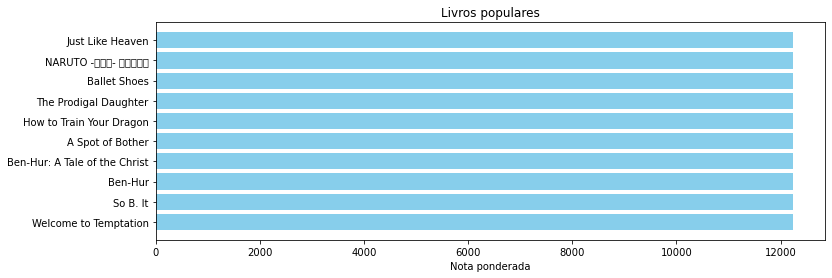

In [37]:
plt.figure(figsize=(12,4))
plt.barh(livros_pop['book_title'].head(10), livros_pop['rating'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Nota ponderada")
plt.title("Livros populares")

**Conclusões deste modelo**

Existem livros bem clássicos na lista, e é curioso perceber como alguns itens infantis (como **Naruto** e **Como Treinar seu Dragão**) chegaram em pontos bastante elevados do ranking.

# Baseado em conteúdo


In [38]:
#Usando a descrição do livro, coluna book_desc
df3['book_desc'].head(5).values

array(['There is a door at the end of a silent corridor. And it’s haunting Harry Pottter’s dreams. Why else would he be waking in the middle of the night, screaming in terror?Harry has a lot on his mind for this, his fifth year at Hogwarts: a Defense Against the Dark Arts teacher with a personality like poisoned honey; a big surprise on the Gryffindor Quidditch team; and the looming terror of the Ordinary Wizarding Level exams. But all these things pale next to the growing threat of He-Who-Must-Not-Be-Named---a threat that neither the magical government nor the authorities at Hogwarts can stop.As the grasp of darkness tightens, Harry must discover the true depth and strength of his friends, the importance of boundless loyalty, and the shocking price of unbearable sacrifice.His fate depends on them alll.(back cover)',
       'لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة سيد الخواتم دخل أفراد رفقة الخاتم فى مغامرات منفصلة أثناء إنجاز المهمة وسيرها فى طريق التنفيذ - اما أراجون الذى كشف أ

In [39]:
#TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df3['book_desc'])

In [40]:
# livros, Palavras distintas
tfidf_matrix.shape

(38154, 250002)

In [41]:
cosine_sim_sinopse = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [42]:
#mapeamento titulo -> indice
livro_idx = dict(zip(df3['book_title'], list(df3.index)))

In [43]:
import sys
!{sys.executable} -m pip install fuzzywuzzy

In [44]:
from fuzzywuzzy import process

In [45]:
#função de recomendação
def get_recommendations(input_title, cosine_sim):
    # Obter indice
    all_titles = df3['book_title'].tolist()
    closest_match = process.extractOne(input_title, all_titles)
    title = closest_match[0]
    print(f"Top-10 mais similares ao livro: {title}")
    idx = livro_idx[title]

    # Obter lista de similaridade
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordenar pela similaridade
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obter 1:11 (top-10 sem o primeiro)
    sim_scores = sim_scores[1:11]
    livro_indices = [i[0] for i in sim_scores]

    # Retornar titulos dos top-10
    return df3['book_title'].iloc[livro_indices]

In [46]:
get_recommendations('Ben Hur', cosine_sim_sinopse)

Top-10 mais similares ao livro: Ben-Hur


1978                 Ben-Hur: A Tale of the Christ
7133                o remorso de baltazar serapião
19558                         A Dama e o Vagabundo
16647                        O Meu Nome é Vermelho
32304                              O Principezinho
18106                         O Museu da Inocência
19562                     Ecos do Futuro - Parte 2
20643                               Ecos do Futuro
33605    O Físico: A Epopéia De Um Médico Medieval
32305                            O Código Da Vinci
Name: book_title, dtype: object

**Conclusões deste modelo**

Como Ben-Hur é a tradução para português, ele trouxe um livro americano que é o próprio livro original em inglês, e diversos livros em português com temas religiosos similares. Aparentemente o modelo funciona e busca os idiomas adequados diante do livro utilizado como base. Infelizmente, este modelo é extremamente pesado de se rodar devido à quantidade de palavras nas descrições. Há de se pensar se valeria a pena quebrar a base ou utilizar outro modelo.

In [47]:
df4 = df3

In [48]:
#condensar gêneros em uma string e colocar tudo em letras minúsculas
df4['genres3'] = df4['genres'].str.lower()
df4['genres3'] = df4['genres3'].str.replace(' ', '')

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/1321663475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['genres3'] = df4['genres'].str.lower()
C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/1321663475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['genres3'] = df4['genres3'].str.replace(' ', '')


In [49]:
df4.head(5)

,book_authors,book_title,book_desc,genres,book_rating,book_rating_count,book_review_count,author1,genre1,genres3
0,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy Young Adult Fiction,4.48,2041594,33264,jkrowling,fantasy,fantasyyoungadultfiction
1,J.R.R. Tolkien,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Fantasy Fiction Classics,4.59,99793,1652,jrrtolkien,fantasy,fantasyfictionclassics
2,Douglas Adams,The Hitchhiker's Guide to the Galaxy,Seconds before the Earth is demolished to make...,Science Fiction Fiction Humor Fantasy Classics,4.21,1155911,23919,douglasadams,sciencefiction,sciencefictionfictionhumorfantasyclassics
3,Shel Silverstein,The Giving Tree,"""Once there was a tree...and she loved a littl...",Childrens Childrens Picture Books Classics Fic...,4.37,789681,15694,shelsilverstein,childrens,childrenschildrenspicturebooksclassicsfiction
4,Dan Brown,The Da Vinci Code,An ingenious code hidden in the works of Leona...,Fiction Mystery Thriller,3.81,1668594,43699,danbrown,fiction,fictionmysterythriller


In [50]:
def juntar_atributos(x):
    return ''.join(x['author1']) + ' ' + ''.join(x['genres3'])

In [51]:
df4['conteudo'] = df4.apply(juntar_atributos, axis=1)

C:\Users\STEFAN~1\AppData\Local\Temp/ipykernel_10360/1934372204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['conteudo'] = df4.apply(juntar_atributos, axis=1)


In [52]:
df4['conteudo'].head(5)

0                   jkrowling fantasyyoungadultfiction
1                    jrrtolkien fantasyfictionclassics
2    douglasadams sciencefictionfictionhumorfantasy...
3    shelsilverstein childrenschildrenspicturebooks...
4                      danbrown fictionmysterythriller
Name: conteudo, dtype: object

In [53]:
#TF
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df4['conteudo'])

In [54]:
cosine_sim_gerais = cosine_similarity(count_matrix, count_matrix)

In [55]:
# mapeamento titulo -> indice
book_idx = dict(zip(df4['book_title'], list(df4.index)))

In [56]:
get_recommendations('Ben Hur', cosine_sim_gerais)

Top-10 mais similares ao livro: Ben-Hur


13096                                              Ben-Hur
0                Harry Potter and the Order of the Phoenix
1        J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
2                     The Hitchhiker's Guide to the Galaxy
3                                          The Giving Tree
4                                        The Da Vinci Code
5        Alice's Adventures in Wonderland & Through the...
6                                         Romeo and Juliet
7                                          Charlotte's Web
8                       The Adventures of Huckleberry Finn
Name: book_title, dtype: object

**Conclusões deste modelo**

É notório que a quantidade de dados utilizada no modelo acima não foi suficiente para criar uma boa similaridade com o livro selecionado, deixando muito a desejar no quesito de precisão.

# Avaliação

- Aplique o melhor modelo escolhido na fase anterior nos dados de teste.
- Discuta os resultados: há sinal de overfitting? o valor é aceitável? o resultado é promissor em termos de negócio? podemos implantar?

O melhor modelo diante dos dados disponíveis para nós é o baseado em conteúdo. Ainda que seu desempenho seja ruim, é nossa melhor hipótese de uso.

Infelizmente, não temos dados dos usuários do Goodreads para fazermos a inferência da Filtragem Colaborativa, que certamente taria grandes ganhos ao nosso modelo.

O resultado parece promissor, mas em um sentido de cold start, precisando com urgência de mais dados de usuários, e dados de usuários da própria plataforma, para compor um modelo melhor.

<a id='implantacao'></a>
# Implantação

- Defina como será implantado. Por exemplo:
    - Modelo embutido em plataformas
    - Dashboard
    - E-mails e/ou mensagens periódicas
    - Relatório mensal
    - Relatório único
    - Uma página
    - Um gráfico
    - Um parágrafo
- O resultado acima se encaixa na implantação pretendida?
    - Dê um exemplo.
    - Por exemplo: Mostre um gráfico, ou preveja um valor para dados desconhecidos, etc.


Minha ideia seria a implantação de um sistema embutido em uma plataforma online, com scraping constante dos dados do Goodreads, com posterior adequação dos mesmos a um modelo de filtragem colaborativa na medida em que usuários da plataforma fossem registrando suas preferências, ratings e reviews.

Seria possível também, caso conseguíssemos dados de usuários de outra plataforma, um cruzamento das bases para conseguir um cold start mais interessante. Infelizmente, em minhas pesquisas on-line, não consegui encontrar esses dados...


<a id='conclusao'></a>
# Conclusão

- Resuma o andamento do projeto, suas descobertas e os resultados que foram obtidos em cada fase.
- Indique onde pesquisas adicionais podem ser feitas ou onde informações adicionais podem ser úteis.
- Caso tenha feito alguma outra análise que não deu certo e não foi incluída aqui, deixe claro.


## Limitações

- Seja claro em relação às limitações do projeto.
    - **Inclua PELO MENOS DUAS LIMITAÇÕES**.

Diante do que foi feito, entendi que realmente é totalmente funcional um modelo de indicação de leitura baseado nas informações dos objetos, especialmente gênero e sinopse, contudo, o modelo fica pobre sem o input de usuários.

Com a indexação de usuários, teríamos a habilidade de compreender quais ratings foram dados por usuários com maior experiência, treinando o modelo de forma mais refinada.

Tentei elaborar uma RME com os modelos utilizados, mas infelizmente minha máquina não tinha memória RAM suficiente para processar o conjunto de dados.

As limitações principais deste modelo são:
    
    - As informações de gênero são dadas pelos usuários, e alguns livros possuem muitos gêneros diferentes, o que imagino que possa dificultar que sejam colocados em uma lista compreensiva, talvez fosse necessária uma revisão disso;
    - Muitos livros possuem ratings diferentes de acordo com a edição e formato (capa mole, capa dura, edição de aniversário) que pouco têm a ver com seu conteúdo, o que pode ocasionar distorções no modelo. Seria interessante uma base de dados baseada unicamente no texto dos livros.

<a id='passo_a_passo'></a>
# Passo a passo para envio

1. Salve este notebook
2. Clique no menu: "Kernel" > "Shutdown"
3. Clique no menu: "Kernel" > "Restart & Run All"
    - Isso executará as células em sequência.
    - Caso haja algum problema/erro em execução de alguma célula, ajeite o erro e volte ao "Passo 1."
    - Caso todas as células sejam executadas sem erro, a célula abaixo também será executada.
    - A célula abaixo cria um HTML com o resultado deste notebook.
4. Zipe o notebook (arquivo .ipynb) e o HTML gerado (arquivo .html)
5. Envie o arquivo ZIP

In [57]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'DSN I - Projeto.ipynb'])

4294967295